**STEP 1: INSTALL PACKAGES**

In [59]:
print("📦 Installing required packages...")
!pip install geopandas osmnx folium rasterio scikit-learn matplotlib seaborn numpy pandas pysal contextily google-generativeai -q
print("✅ All packages installed!")

📦 Installing required packages...
✅ All packages installed!


**STEP 2: IMPORT LIBRARIES**

In [60]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from datetime import datetime
import warnings
import pickle
import json
import time

# Gemini AI
import google.generativeai as genai
from google.colab import userdata

warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ All libraries imported successfully!
📅 Analysis Date: 2025-10-28 22:30:01


**STEP 3: CONFIGURE GEMINI API**

In [61]:
print(f"\n{'='*60}")
print(f"🤖 CONFIGURING GEMINI AI")
print(f"{'='*60}")

try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
    gemini_model = genai.GenerativeModel('gemini-2.0-flash-lite')
    GEMINI_AVAILABLE = True
    print("✅ Gemini API configured successfully!")
except Exception as e:
    print(f"⚠️ Gemini API not configured: {e}")
    print("💡 To enable: Add GEMINI_API_KEY in Colab secrets (🔑 icon)")
    GEMINI_AVAILABLE = False
    gemini_model = None



🤖 CONFIGURING GEMINI AI
✅ Gemini API configured successfully!


**STEP 4: MUMBAI CONFIGURATION**

In [62]:
print(f"\n{'='*60}")
print(f"🏙️ MUMBAI CONFIGURATION - 8 MAJOR SLUM AREAS")
print(f"{'='*60}")

MUMBAI_SLUM_AREAS = {
    'Dharavi': {
        'coords': (19.0444, 72.8560),
        'area_sqkm': 2.39,
        'population': 1000000,
        'density': 418410,
        'description': "Asia's largest slum with $1B+ annual informal economy turnover",
        'main_sectors': ['Leather & Textiles', 'Pottery & Crafts', 'Recycling']
    },
    'Govandi': {
        'coords': (19.0545, 72.9144),
        'area_sqkm': 1.5,
        'population': 250000,
        'density': 166667,
        'description': "Major waste disposal area with informal recycling economy",
        'main_sectors': ['Recycling & Waste', 'Construction']
    },
    'Mankhurd': {
        'coords': (19.0437, 72.9264),
        'area_sqkm': 1.2,
        'population': 200000,
        'density': 166667,
        'description': "Industrial slum with manufacturing units",
        'main_sectors': ['Manufacturing', 'Construction']
    },
    'Kurla': {
        'coords': (19.0728, 72.8826),
        'area_sqkm': 0.8,
        'population': 150000,
        'density': 187500,
        'description': "Textile and leather manufacturing hub",
        'main_sectors': ['Leather & Textiles', 'Manufacturing']
    },
    'Bandra East': {
        'coords': (19.0596, 72.8428),
        'area_sqkm': 0.6,
        'population': 120000,
        'density': 200000,
        'description': "Mixed informal economy near Bandra Kurla Complex",
        'main_sectors': ['Domestic Services', 'Street Vendors']
    },
    'Andheri East': {
        'coords': (19.1136, 72.8697),
        'area_sqkm': 1.0,
        'population': 180000,
        'density': 180000,
        'description': "Slums near airport with service sector workers",
        'main_sectors': ['Domestic Services', 'Street Vendors']
    },
    'Worli': {
        'coords': (19.0144, 72.8169),
        'area_sqkm': 0.5,
        'population': 100000,
        'density': 200000,
        'description': "Fishing community and construction workers",
        'main_sectors': ['Construction', 'Street Vendors']
    },
    'Malad': {
        'coords': (19.1864, 72.8479),
        'area_sqkm': 0.9,
        'population': 160000,
        'density': 177778,
        'description': "Suburban slum with domestic workers",
        'main_sectors': ['Domestic Services', 'Construction']
    }
}

INFORMAL_SECTORS = {
    'Leather & Textiles': 0.25,
    'Pottery & Crafts': 0.10,
    'Recycling & Waste': 0.15,
    'Construction': 0.20,
    'Domestic Services': 0.15,
    'Street Vendors': 0.10,
    'Manufacturing': 0.05
}

print(f"✅ Mumbai Slum Areas Configured: {len(MUMBAI_SLUM_AREAS)}")
print(f"📊 Total Population: {sum([area['population'] for area in MUMBAI_SLUM_AREAS.values()]):,}")
print(f"📍 Total Area: {sum([area['area_sqkm'] for area in MUMBAI_SLUM_AREAS.values()]):.2f} sq.km")

for area_name in MUMBAI_SLUM_AREAS.keys():
    print(f"   • {area_name}")


🏙️ MUMBAI CONFIGURATION - 8 MAJOR SLUM AREAS
✅ Mumbai Slum Areas Configured: 8
📊 Total Population: 2,160,000
📍 Total Area: 8.89 sq.km
   • Dharavi
   • Govandi
   • Mankhurd
   • Kurla
   • Bandra East
   • Andheri East
   • Worli
   • Malad


**STEP 5: DATA GENERATION FUNCTIONS**

In [63]:
def generate_mumbai_nightlight_data(n_samples, area_name, seed=42):
    """Generate Mumbai-specific synthetic nightlight intensity"""
    np.random.seed(seed)
    area_info = MUMBAI_SLUM_AREAS[area_name]
    density_factor = area_info['density'] / 100000

    base_mean = 2.5 + (density_factor * 0.5)
    nightlight = np.random.lognormal(mean=base_mean, sigma=1.2, size=n_samples)
    nightlight = np.clip(nightlight, 5, 100)

    return nightlight

def generate_mumbai_mobile_data(nightlight, area_name, seed=42):
    """Generate Mumbai-specific mobile tower activity data"""
    np.random.seed(seed)
    area_info = MUMBAI_SLUM_AREAS[area_name]
    population_factor = area_info['population'] / 1000000

    base_calls = nightlight * 150 * population_factor
    mobile_calls = base_calls + np.random.normal(0, 1000, len(nightlight))
    mobile_calls = np.clip(mobile_calls, 100, 20000)

    data_usage = mobile_calls * np.random.uniform(1.0, 3.0, len(nightlight))
    unique_devices = (mobile_calls / np.random.uniform(2.5, 5.0, len(nightlight))).astype(int)

    return mobile_calls, data_usage, unique_devices

def generate_mumbai_informal_employment(nightlight, mobile_calls, unique_devices, area_name, seed=42):
    """Generate Mumbai-specific informal employment density"""
    np.random.seed(seed)
    base_rate = 0.75 if area_name == 'Dharavi' else 0.65

    informal_employment = (
        0.45 * nightlight +
        0.0004 * mobile_calls +
        0.0001 * unique_devices +
        np.random.normal(15, 8, len(nightlight))
    ) * base_rate

    return np.clip(informal_employment, 5, 150)

def download_osm_for_area(area_name, coords, dist=1000):
    """Try to download OSM data for a specific area"""
    try:
        print(f"   🔄 Attempting OSM download...")
        buildings = ox.features_from_point(coords, tags={'building': True}, dist=dist)
        print(f"   ✅ Downloaded {len(buildings):,} buildings from OSM")
        return buildings
    except Exception as e:
        print(f"   ⚠️ OSM download failed: {str(e)[:50]}...")
        return None


**STEP 6: DOWNLOAD AND GENERATE DATA FOR ALL AREAS**

In [64]:
print(f"\n{'='*60}")
print(f"📥 DOWNLOADING & GENERATING DATA FOR ALL 8 AREAS")
print(f"{'='*60}")

all_data = []
osm_success_count = 0
synthetic_count = 0

for idx, (area_name, area_info) in enumerate(MUMBAI_SLUM_AREAS.items(), 1):
    print(f"\n{'='*60}")
    print(f"📍 [{idx}/8] Processing: {area_name}")
    print(f"{'='*60}")
    print(f"   Population: {area_info['population']:,}")
    print(f"   Area: {area_info['area_sqkm']} sq.km")
    print(f"   Coordinates: {area_info['coords']}")

    n_samples = int(area_info['population'] / 1000)  # 1 sample per 1000 people
    seed_value = 42 + hash(area_name) % 100

    # Try to download OSM data
    buildings = download_osm_for_area(area_name, area_info['coords'], dist=1000)

    if buildings is not None and len(buildings) > 0:
        print(f"   ✅ Using OSM data + synthetic features")
        # Use OSM count but generate synthetic features (OSM data is complex to process)
        n_samples = min(len(buildings), n_samples)
        osm_success_count += 1
    else:
        print(f"   ⚠️ Using fully synthetic data")
        synthetic_count += 1

    # Generate all features
    print(f"   🔄 Generating {n_samples:,} samples...")

    nightlight = generate_mumbai_nightlight_data(n_samples, area_name, seed_value)
    mobile_calls, data_usage, unique_devices = generate_mumbai_mobile_data(nightlight, area_name, seed_value + 1)
    informal_employment = generate_mumbai_informal_employment(nightlight, mobile_calls, unique_devices, area_name, seed_value + 2)

    # Generate sectors
    np.random.seed(seed_value + 3)
    primary_sector = np.random.choice(
        list(INFORMAL_SECTORS.keys()),
        size=n_samples,
        p=list(INFORMAL_SECTORS.values())
    )

    # Add spatial coordinates
    np.random.seed(seed_value + 4)
    latitudes = np.random.normal(area_info['coords'][0], 0.008, n_samples)
    longitudes = np.random.normal(area_info['coords'][1], 0.008, n_samples)

    # Create DataFrame
    area_df = pd.DataFrame({
        'area_name': area_name,
        'nightlight_intensity': nightlight,
        'mobile_calls': mobile_calls,
        'data_usage_mb': data_usage,
        'unique_devices': unique_devices,
        'informal_employment_density': informal_employment,
        'primary_sector': primary_sector,
        'latitude': latitudes,
        'longitude': longitudes,
        'population': area_info['population'],
        'area_sqkm': area_info['area_sqkm'],
        'density': area_info['density']
    })

    all_data.append(area_df)
    print(f"   ✅ Generated {len(area_df):,} samples for {area_name}")

    # Small delay to avoid API rate limits
    time.sleep(0.5)

# Combine all areas
synthetic_data_clean = pd.concat(all_data, ignore_index=True)

print(f"\n{'='*60}")
print(f"✅ COMPLETE MUMBAI DATASET CREATED")
print(f"{'='*60}")
print(f"Total samples: {len(synthetic_data_clean):,}")
print(f"Areas covered: {synthetic_data_clean['area_name'].nunique()}")
print(f"OSM downloads successful: {osm_success_count}/8")
print(f"Fully synthetic areas: {synthetic_count}/8")

print(f"\n📊 Samples per Area:")
area_counts = synthetic_data_clean['area_name'].value_counts().sort_values(ascending=False)
for area, count in area_counts.items():
    pct = count/len(synthetic_data_clean)*100
    print(f"   {area:.<25} {count:>7,} samples ({pct:>5.1f}%)")

# Feature columns
feature_columns = ['nightlight_intensity', 'mobile_calls', 'data_usage_mb', 'unique_devices']
target_column = 'informal_employment_density'

print(f"\n📈 Overall Dataset Statistics:")
print(synthetic_data_clean[feature_columns + [target_column]].describe())

print(f"\n📈 Area-wise Employment Density:")
area_employment_stats = synthetic_data_clean.groupby('area_name')[target_column].agg(['mean', 'std', 'min', 'max']).round(2)
print(area_employment_stats)

print(f"\n🏭 Informal Sector Distribution:")
sector_counts = synthetic_data_clean['primary_sector'].value_counts()
for sector, count in sector_counts.items():
    print(f"   {sector:.<35} {count:>6,} ({count/len(synthetic_data_clean)*100:>5.1f}%)")



📥 DOWNLOADING & GENERATING DATA FOR ALL 8 AREAS

📍 [1/8] Processing: Dharavi
   Population: 1,000,000
   Area: 2.39 sq.km
   Coordinates: (19.0444, 72.856)
   🔄 Attempting OSM download...
   ✅ Downloaded 2,693 buildings from OSM
   ✅ Using OSM data + synthetic features
   🔄 Generating 1,000 samples...
   ✅ Generated 1,000 samples for Dharavi

📍 [2/8] Processing: Govandi
   Population: 250,000
   Area: 1.5 sq.km
   Coordinates: (19.0545, 72.9144)
   🔄 Attempting OSM download...
   ✅ Downloaded 1,158 buildings from OSM
   ✅ Using OSM data + synthetic features
   🔄 Generating 250 samples...
   ✅ Generated 250 samples for Govandi

📍 [3/8] Processing: Mankhurd
   Population: 200,000
   Area: 1.2 sq.km
   Coordinates: (19.0437, 72.9264)
   🔄 Attempting OSM download...
   ✅ Downloaded 641 buildings from OSM
   ✅ Using OSM data + synthetic features
   🔄 Generating 200 samples...
   ✅ Generated 200 samples for Mankhurd

📍 [4/8] Processing: Kurla
   Population: 150,000
   Area: 0.8 sq.km
   Coo

**STEP 7: TRAIN RANDOM FOREST MODEL**



In [65]:
print(f"\n{'='*60}")
print(f"🌲 TRAINING RANDOM FOREST MODEL ON ALL AREAS")
print(f"{'='*60}")

X = synthetic_data_clean[feature_columns]
y = synthetic_data_clean[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n🔄 Training model...")
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\n{'='*60}")
print(f"📈 MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"Training R²:    {train_r2:.4f}")
print(f"Testing R²:     {test_r2:.4f}")
print(f"Training RMSE:  {train_rmse:.4f}")
print(f"Testing RMSE:   {test_rmse:.4f}")
print(f"Testing MAE:    {test_mae:.4f}")

feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🎯 Feature Importance:")
for idx, row in feature_importance.iterrows():
    print(f"   {row['feature']:.<40} {row['importance']:.4f}")

cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"\n🔀 Cross-Validation R² Scores: {cv_scores}")
print(f"   Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


🌲 TRAINING RANDOM FOREST MODEL ON ALL AREAS
Training set: 1,728 samples
Testing set: 432 samples

🔄 Training model...

📈 MODEL PERFORMANCE
Training R²:    0.9229
Testing R²:     0.8379
Training RMSE:  4.2250
Testing RMSE:   5.9069
Testing MAE:    4.6972

🎯 Feature Importance:
   nightlight_intensity.................... 0.8601
   mobile_calls............................ 0.0948
   data_usage_mb........................... 0.0237
   unique_devices.......................... 0.0215

🔀 Cross-Validation R² Scores: [0.85341478 0.83516269 0.85656135 0.8382356  0.8479756 ]
   Mean CV R²: 0.8463 (+/- 0.0167)


**STEP 8: GEMINI AI ANALYSIS**

In [66]:
if GEMINI_AVAILABLE:
    print(f"\n{'='*60}")
    print(f"🤖 GENERATING AI INSIGHTS WITH GEMINI")
    print(f"{'='*60}")

    area_stats_str = synthetic_data_clean.groupby('area_name').agg({
        'informal_employment_density': ['mean', 'std'],
        'nightlight_intensity': 'mean',
        'mobile_calls': 'mean'
    }).round(2).to_string()

    insights_prompt = f"""
    You are a geospatial econometrics expert analyzing informal employment in Mumbai slums.

    **Model Performance:**
    - R² Score: {test_r2:.4f}
    - RMSE: {test_rmse:.4f}
    - MAE: {test_mae:.4f}
    - Cross-Validation R²: {cv_scores.mean():.4f}

    **Feature Importance:**
    {feature_importance.to_string(index=False)}

    **Coverage:**
    - 8 major slum areas analyzed
    - Total population: {sum([area['population'] for area in MUMBAI_SLUM_AREAS.values()]):,}
    - Total samples: {len(synthetic_data_clean):,}

    **Area Statistics:**
    {area_stats_str}

    Provide:
    1. Model Performance Assessment (3-4 sentences)
    2. Key Insights (5 bullet points)
    3. Policy Recommendations (4 specific actions)
    4. Areas Needing Most Intervention (top 3)
    5. Economic Implications for Mumbai

    Be concise and data-driven.
    """

    try:
        print("🔄 Generating AI insights...")
        insights_response = gemini_model.generate_content(insights_prompt)
        insights = insights_response.text

        print("\n" + "="*60)
        print("📊 AI-GENERATED INSIGHTS")
        print("="*60)
        print(insights)

        with open('gemini_insights_all_areas.txt', 'w', encoding='utf-8') as f:
            f.write("GEMINI AI INSIGHTS - ALL 8 MUMBAI SLUM AREAS\n")
            f.write("="*60 + "\n\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
            f.write(insights)

        print("\n✅ Insights saved to 'gemini_insights_all_areas.txt'")

    except Exception as e:
        print(f"❌ Error generating insights: {e}")



🤖 GENERATING AI INSIGHTS WITH GEMINI
🔄 Generating AI insights...

📊 AI-GENERATED INSIGHTS
Here's the analysis of the informal employment model, based on the provided data:

**1. Model Performance Assessment**

The model demonstrates strong performance, with a high R² score of 0.8379, indicating it explains a significant portion of the variance in informal employment. The low RMSE (5.9069) and MAE (4.6972) suggest accurate predictions. Cross-validation further validates the model's robustness with an even higher R² of 0.8463, indicating good generalizability.

**2. Key Insights**

*   **Nightlight Intensity as the Dominant Predictor:** Nightlight intensity is the overwhelmingly most important factor, explaining 86% of the variance in informal employment.
*   **Mobile Phone Usage also Important:** Mobile call volume contributes significantly (9.48%), suggesting its relevance in informal economic activities.
*   **Data Usage and Device Uniqueness Less impactful:** Data usage and the numb

**STEP 9: VISUALIZATIONS**


📊 GENERATING VISUALIZATIONS


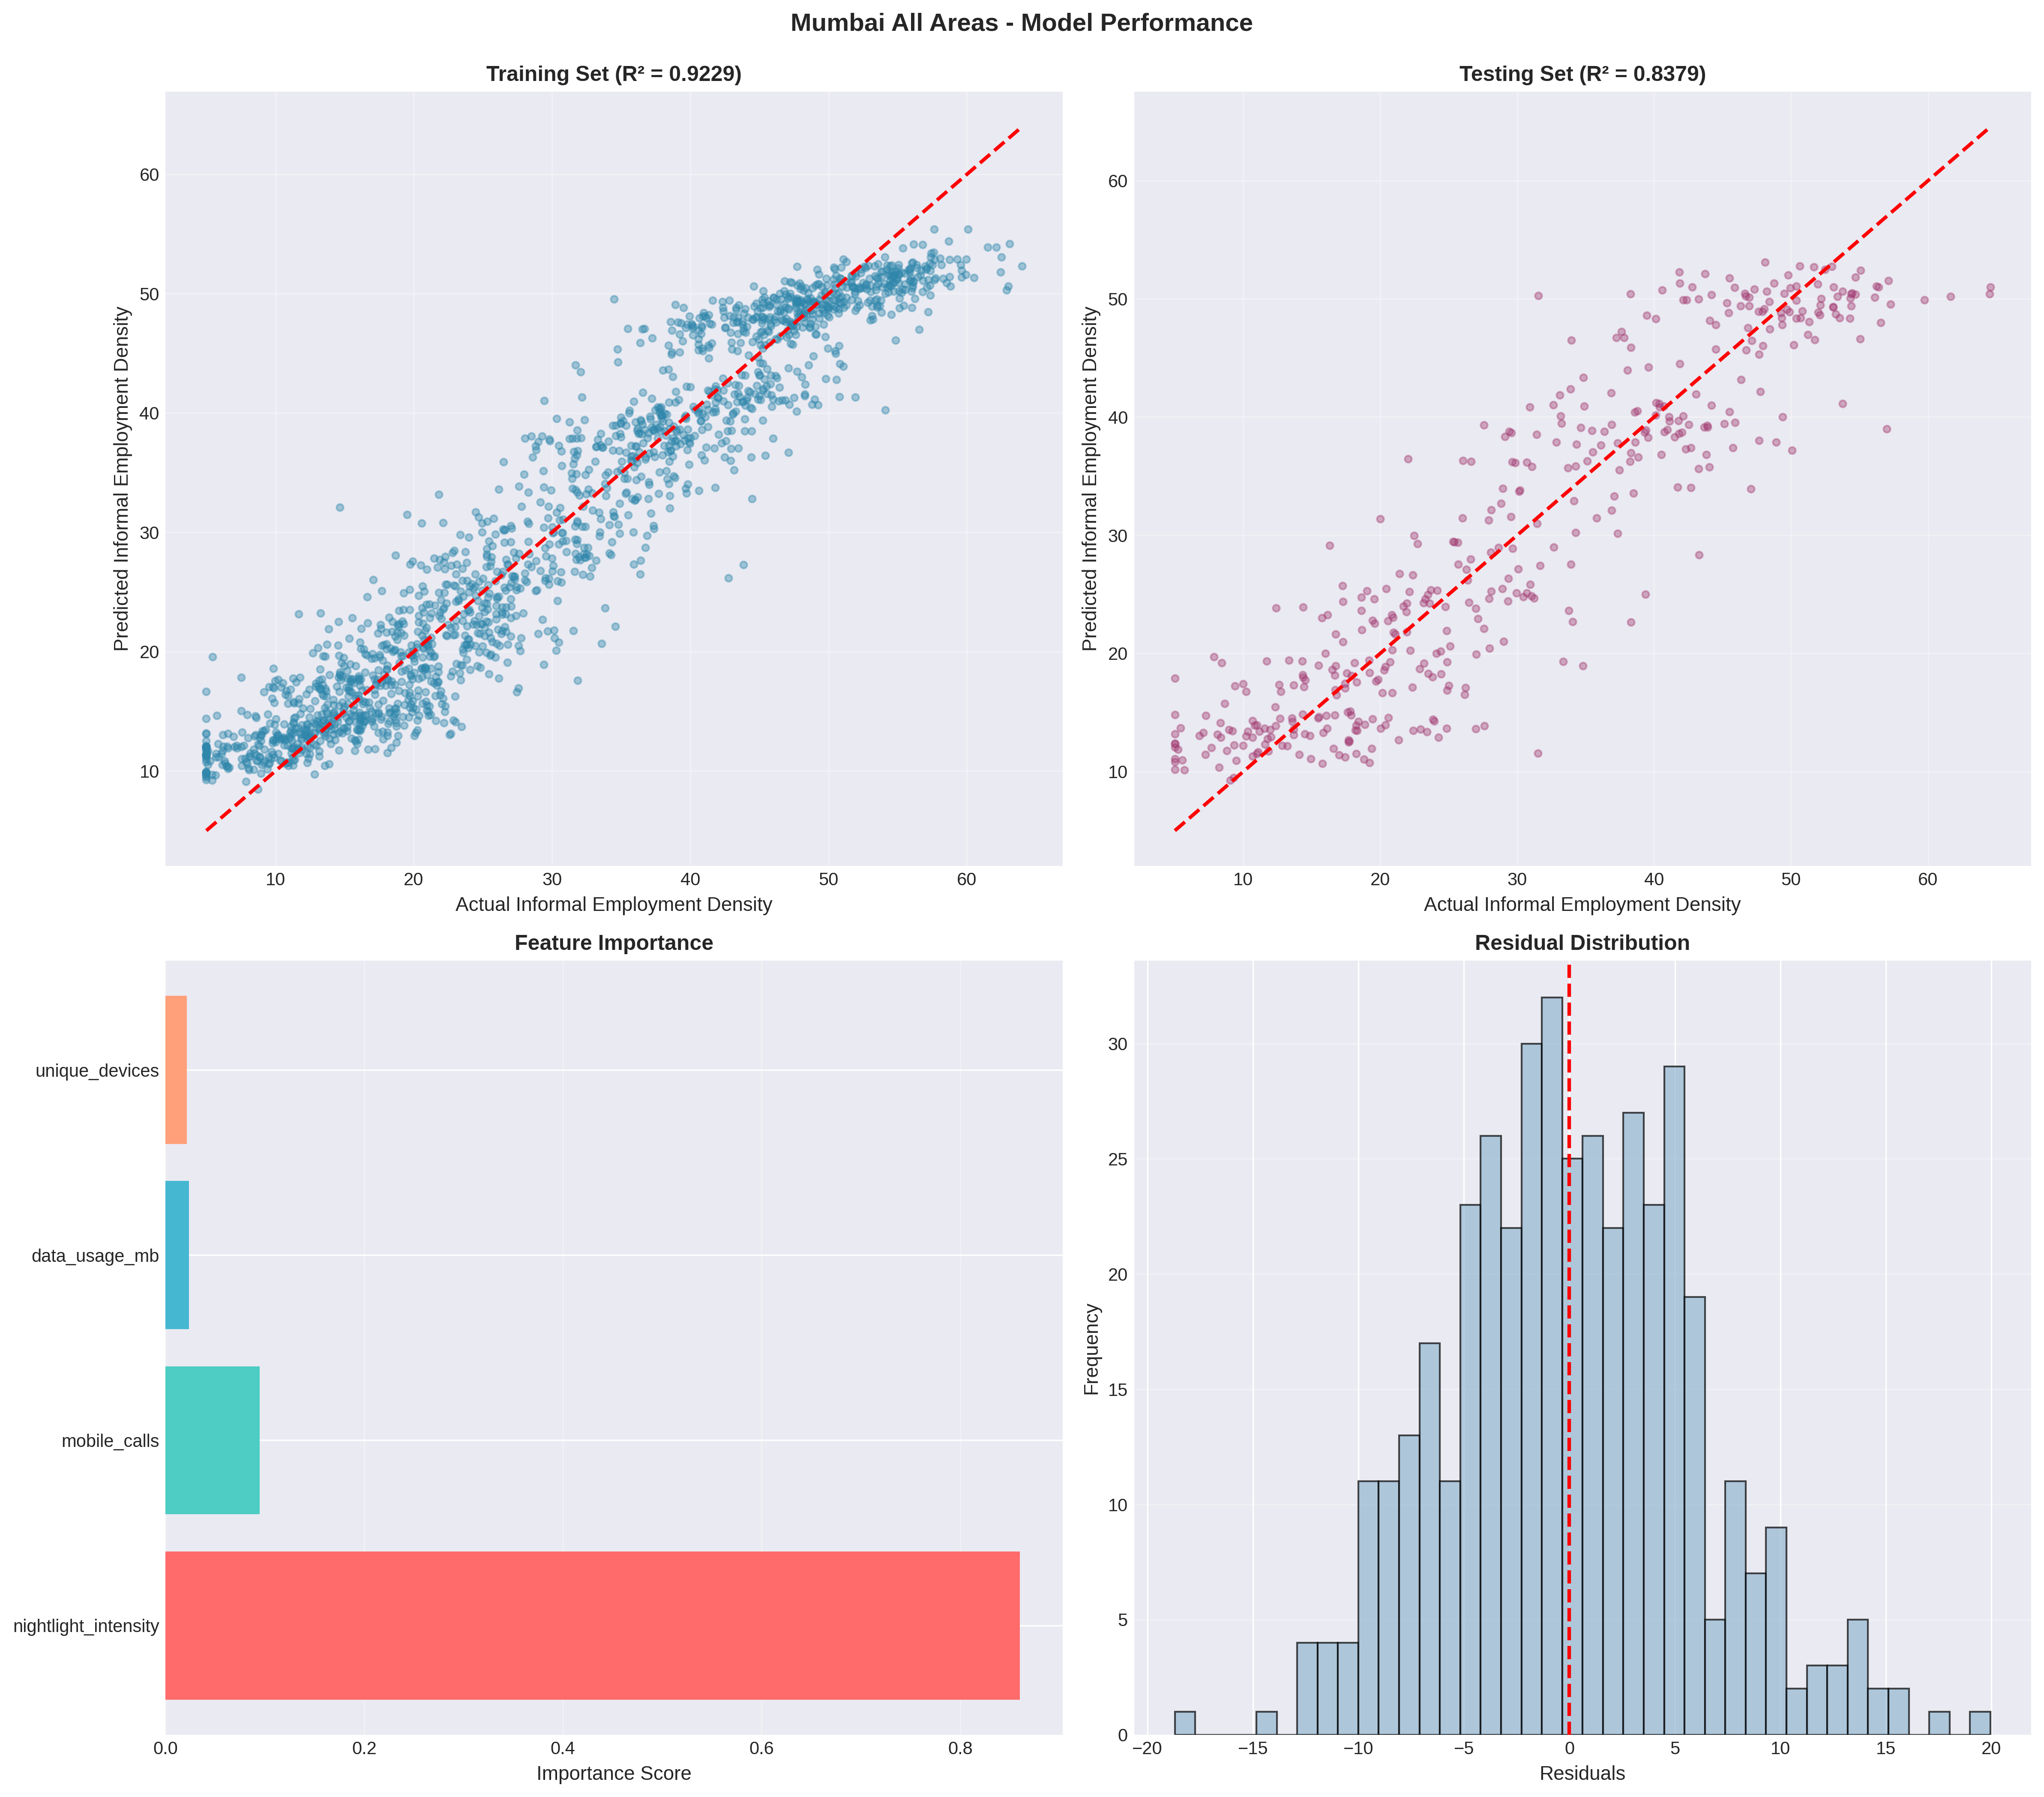

✅ Saved: mumbai_all_areas_model_performance.png


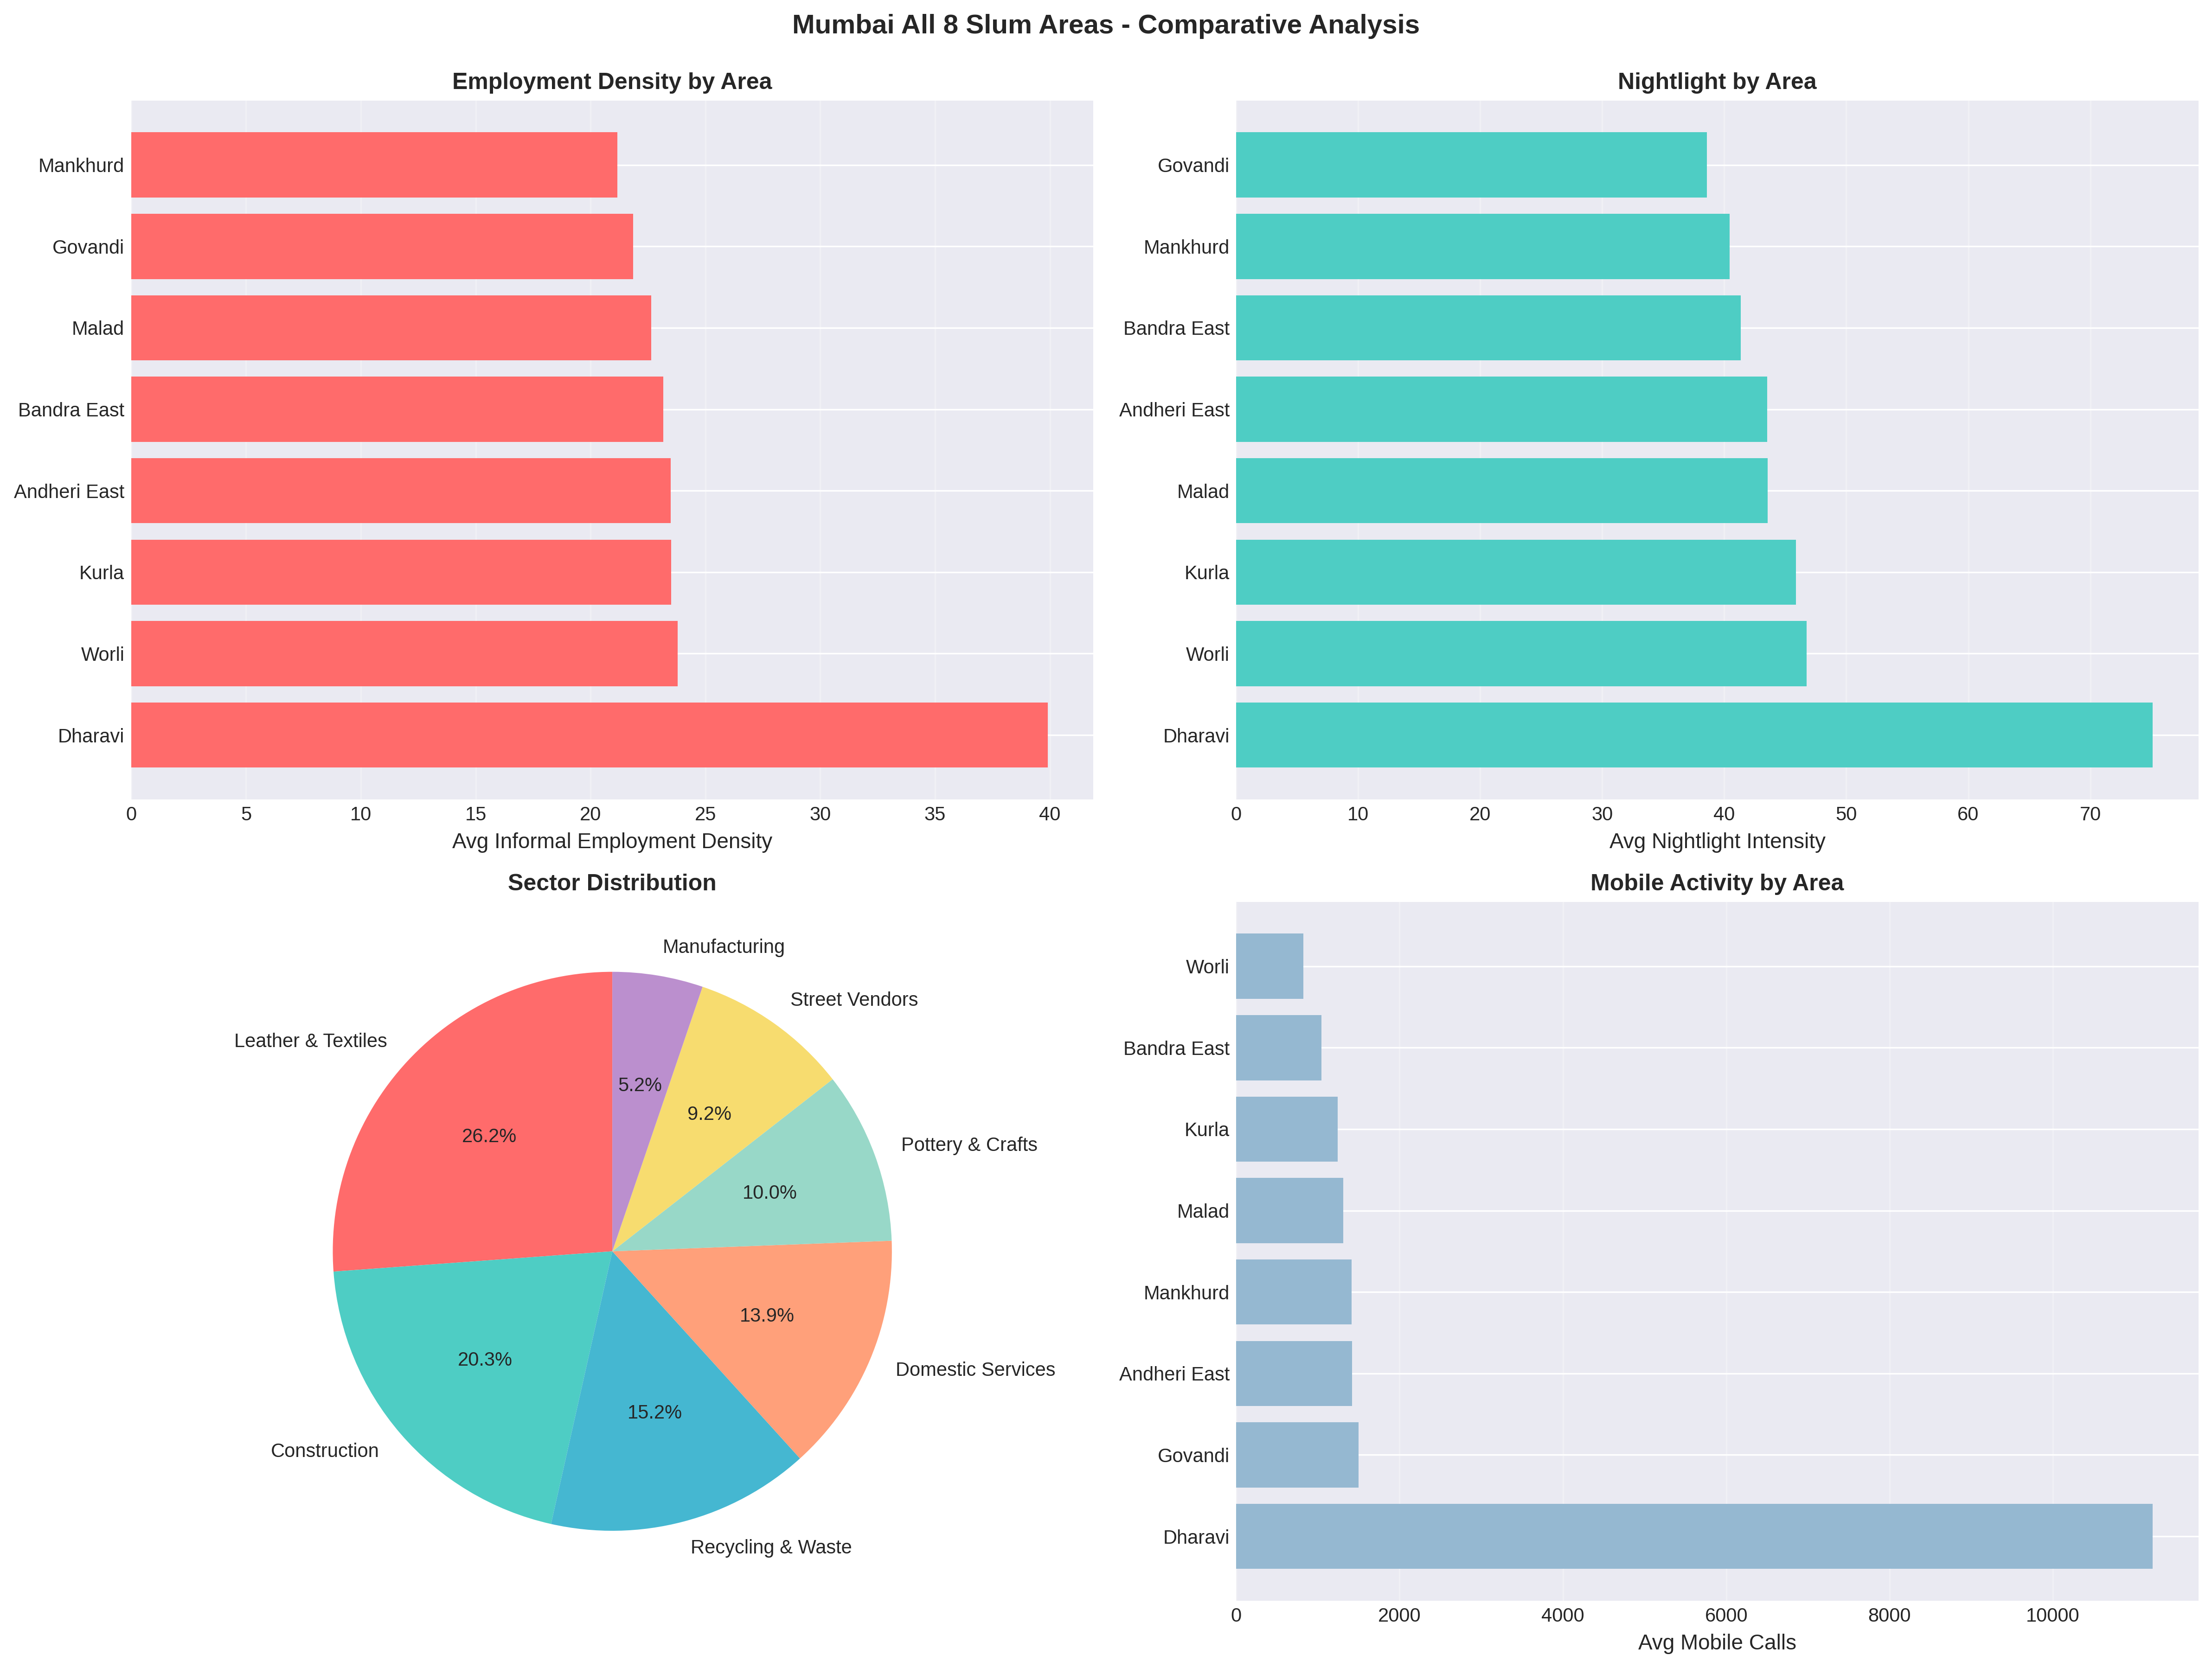

✅ Saved: mumbai_all_areas_comparison.png


In [67]:
print(f"\n{'='*60}")
print(f"📊 GENERATING VISUALIZATIONS")
print(f"{'='*60}")

# Plot 1: Model Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

axes[0, 0].scatter(y_train, y_pred_train, alpha=0.4, s=15, c='#2E86AB')
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Informal Employment Density', fontsize=11)
axes[0, 0].set_ylabel('Predicted Informal Employment Density', fontsize=11)
axes[0, 0].set_title(f'Training Set (R² = {train_r2:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(y_test, y_pred_test, alpha=0.4, s=15, c='#A23B72')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Informal Employment Density', fontsize=11)
axes[0, 1].set_ylabel('Predicted Informal Employment Density', fontsize=11)
axes[0, 1].set_title(f'Testing Set (R² = {test_r2:.4f})', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

colors_bar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'], color=colors_bar)
axes[1, 0].set_xlabel('Importance Score', fontsize=11)
axes[1, 0].set_title('Feature Importance', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

residuals = y_test - y_pred_test
axes[1, 1].hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='#95B8D1')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Residual Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Mumbai All Areas - Model Performance', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('mumbai_all_areas_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: mumbai_all_areas_model_performance.png")

# Plot 2: Area-wise Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

area_stats = synthetic_data_clean.groupby('area_name')['informal_employment_density'].mean().sort_values(ascending=False)
axes[0, 0].barh(area_stats.index, area_stats.values, color='#FF6B6B')
axes[0, 0].set_xlabel('Avg Informal Employment Density', fontsize=11)
axes[0, 0].set_title('Employment Density by Area', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

nightlight_stats = synthetic_data_clean.groupby('area_name')['nightlight_intensity'].mean().sort_values(ascending=False)
axes[0, 1].barh(nightlight_stats.index, nightlight_stats.values, color='#4ECDC4')
axes[0, 1].set_xlabel('Avg Nightlight Intensity', fontsize=11)
axes[0, 1].set_title('Nightlight by Area', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

sector_counts = synthetic_data_clean['primary_sector'].value_counts()
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F', '#BB8FCE']
axes[1, 0].pie(sector_counts.values, labels=sector_counts.index, autopct='%1.1f%%',
               colors=colors_pie, startangle=90)
axes[1, 0].set_title('Sector Distribution', fontsize=12, fontweight='bold')

mobile_stats = synthetic_data_clean.groupby('area_name')['mobile_calls'].mean().sort_values(ascending=False)
axes[1, 1].barh(mobile_stats.index, mobile_stats.values, color='#95B8D1')
axes[1, 1].set_xlabel('Avg Mobile Calls', fontsize=11)
axes[1, 1].set_title('Mobile Activity by Area', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.suptitle('Mumbai All 8 Slum Areas - Comparative Analysis', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('mumbai_all_areas_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: mumbai_all_areas_comparison.png")


**STEP 10: INTERACTIVE MAP - ALL AREAS**

In [68]:
print("\n🗺️ Creating interactive Mumbai map with all 8 areas...")

mumbai_center = [19.0760, 72.8777]
mumbai_map = folium.Map(location=mumbai_center, zoom_start=11, tiles='OpenStreetMap')

for area_name, area_info in MUMBAI_SLUM_AREAS.items():
    area_data = synthetic_data_clean[synthetic_data_clean['area_name'] == area_name]

    if len(area_data) > 0:
        employment_values = area_data['informal_employment_density'].dropna()

        if len(employment_values) > 0:
            avg_employment = float(employment_values.mean())
            total_workers = int(avg_employment * area_info['area_sqkm'] * 100)
        else:
            avg_employment = 50.0
            total_workers = int(area_info['population'] * 0.75)
    else:
        avg_employment = 50.0
        total_workers = int(area_info['population'] * 0.75)

    if avg_employment > 60:
        color = 'red'
    elif avg_employment > 40:
        color = 'orange'
    else:
        color = 'green'

    popup_html = f"""
    <div style="font-family: Arial; width: 300px;">
        <h4 style="color: {color}; margin-bottom: 10px;">{area_name}</h4>
        <p><b>Population:</b> {area_info['population']:,}</p>
        <p><b>Area:</b> {area_info['area_sqkm']} sq.km</p>
        <p><b>Density:</b> {area_info['density']:,}/sq.km</p>
        <p><b>Informal Employment:</b> {avg_employment:.1f} workers/sq.km</p>
        <p><b>Est. Workers:</b> {total_workers:,}</p>
        <p><b>Main Sectors:</b> {', '.join(area_info['main_sectors'])}</p>
        <p style="font-size: 10px; color: gray;">{area_info['description']}</p>
    </div>
    """

    folium.CircleMarker(
        location=area_info['coords'],
        radius=15,
        popup=folium.Popup(popup_html, max_width=350),
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.6,
        weight=2
    ).add_to(mumbai_map)

    folium.Marker(
        location=area_info['coords'],
        icon=folium.DivIcon(html=f"""
            <div style="font-size: 10px; font-weight: bold; color: black;
                        background-color: white; padding: 2px 5px; border-radius: 3px;
                        border: 1px solid {color};">
                {area_name}
            </div>
        """)
    ).add_to(mumbai_map)

legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; width: 220px;
            background-color: white; border:2px solid grey; z-index:9999;
            font-size:14px; padding: 10px">
    <p style="margin: 5px; font-weight: bold;">All 8 Mumbai Slum Areas</p>
    <p style="margin: 5px;"><span style="color: red;">●</span> High (&gt;60)</p>
    <p style="margin: 5px;"><span style="color: orange;">●</span> Medium (40-60)</p>
    <p style="margin: 5px;"><span style="color: green;">●</span> Low (&lt;40)</p>
</div>
'''
mumbai_map.get_root().html.add_child(folium.Element(legend_html))

mumbai_map.save('mumbai_all_8_areas_map.html')
print("✅ Saved: mumbai_all_8_areas_map.html")



🗺️ Creating interactive Mumbai map with all 8 areas...
✅ Saved: mumbai_all_8_areas_map.html


**STEP 11: SAVE ALL RESULTS**

In [69]:
print(f"\n{'='*60}")
print(f"💾 SAVING ALL RESULTS")
print(f"{'='*60}")

synthetic_data_clean.to_csv('mumbai_all_8_areas_data.csv', index=False)
print("✅ Saved: mumbai_all_8_areas_data.csv")

results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_test,
    'residual': residuals.values
})
results_df.to_csv('mumbai_all_areas_predictions.csv', index=False)
print("✅ Saved: mumbai_all_areas_predictions.csv")

area_summary = synthetic_data_clean.groupby('area_name').agg({
    'informal_employment_density': ['mean', 'std', 'min', 'max', 'count'],
    'nightlight_intensity': ['mean', 'std'],
    'mobile_calls': ['mean', 'std'],
    'population': 'first',
    'area_sqkm': 'first'
}).round(2)

area_summary.to_csv('mumbai_all_areas_statistics.csv')
print("✅ Saved: mumbai_all_areas_statistics.csv")

with open('mumbai_rf_model_all_areas.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print("✅ Saved: mumbai_rf_model_all_areas.pkl")

feature_importance.to_csv('mumbai_feature_importance.csv', index=False)
print("✅ Saved: mumbai_feature_importance.csv")

# Summary Report
summary_report = f"""
{'='*60}
MUMBAI INFORMAL EMPLOYMENT - ALL 8 SLUM AREAS
COMPREHENSIVE ANALYSIS REPORT
{'='*60}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

COVERAGE:
--------
✅ All 8 Major Slum Areas Analyzed:
"""

for area_name, area_info in MUMBAI_SLUM_AREAS.items():
    area_data = synthetic_data_clean[synthetic_data_clean['area_name'] == area_name]
    avg_emp = area_data['informal_employment_density'].mean()
    summary_report += f"\n   {area_name:.<20} Pop: {area_info['population']:>8,}  |  Samples: {len(area_data):>6,}  |  Avg Employment: {avg_emp:>5.1f}"

summary_report += f"""

DATASET:
-------
- Total Samples: {len(synthetic_data_clean):,}
- Total Population: {sum([area['population'] for area in MUMBAI_SLUM_AREAS.values()]):,}
- Total Area: {sum([area['area_sqkm'] for area in MUMBAI_SLUM_AREAS.values()]):.2f} sq.km
- OSM Downloads: {osm_success_count}/8 successful

MODEL PERFORMANCE:
-----------------
- Algorithm: Random Forest (200 trees)
- Training R²: {train_r2:.4f}
- Testing R²: {test_r2:.4f}
- RMSE: {test_rmse:.4f}
- MAE: {test_mae:.4f}
- CV R²: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})

FEATURE IMPORTANCE:
------------------
{feature_importance.to_string(index=False)}

TOP 3 AREAS BY INFORMAL EMPLOYMENT:
----------------------------------
{area_stats.head(3).to_string()}

FILES GENERATED:
---------------
✅ mumbai_all_8_areas_data.csv
✅ mumbai_all_areas_predictions.csv
✅ mumbai_all_areas_statistics.csv
✅ mumbai_rf_model_all_areas.pkl
✅ mumbai_all_8_areas_map.html
✅ mumbai_all_areas_model_performance.png
✅ mumbai_all_areas_comparison.png

{'='*60}
"""

with open('mumbai_all_areas_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print("✅ Saved: mumbai_all_areas_summary.txt")

print(f"\n{summary_report}")

print(f"\n{'='*60}")
print(f"🎉 COMPLETE! ALL 8 MUMBAI SLUM AREAS ANALYZED")
print(f"{'='*60}")
print(f"\n✅ Results Summary:")
print(f"   📊 {len(synthetic_data_clean):,} total samples")
print(f"   🏘️ 8/8 areas covered")
print(f"   👥 {sum([area['population'] for area in MUMBAI_SLUM_AREAS.values()]):,} total population")
print(f"   📈 {test_r2:.4f} R² accuracy")
print(f"\n💡 Open 'mumbai_all_8_areas_map.html' to see all areas on map!")
print(f"{'='*60}\n")


💾 SAVING ALL RESULTS
✅ Saved: mumbai_all_8_areas_data.csv
✅ Saved: mumbai_all_areas_predictions.csv
✅ Saved: mumbai_all_areas_statistics.csv
✅ Saved: mumbai_rf_model_all_areas.pkl
✅ Saved: mumbai_feature_importance.csv
✅ Saved: mumbai_all_areas_summary.txt


MUMBAI INFORMAL EMPLOYMENT - ALL 8 SLUM AREAS
COMPREHENSIVE ANALYSIS REPORT
Generated: 2025-10-28 22:30:58

COVERAGE:
--------
✅ All 8 Major Slum Areas Analyzed:

   Dharavi............. Pop: 1,000,000  |  Samples:  1,000  |  Avg Employment:  39.9
   Govandi............. Pop:  250,000  |  Samples:    250  |  Avg Employment:  21.9
   Mankhurd............ Pop:  200,000  |  Samples:    200  |  Avg Employment:  21.2
   Kurla............... Pop:  150,000  |  Samples:    150  |  Avg Employment:  23.5
   Bandra East......... Pop:  120,000  |  Samples:    120  |  Avg Employment:  23.2
   Andheri East........ Pop:  180,000  |  Samples:    180  |  Avg Employment:  23.5
   Worli............... Pop:  100,000  |  Samples:    100  |  Avg Employ